# Lab 12 - Training Deep Convolutional Neural Network
- Jinna Wannasopa, 64070501060

Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [1]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from keras.utils import np_utils
from keras.utils import to_categorical
# from keras.layers.convolutional import  MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model, test_features, test_labels, batch_size=32):
    # Calculate the number of samples in the test set
    num_samples = len(test_labels)

    # Predict classes for the test set
    pred_probs = model.predict(test_features, batch_size=batch_size)
    pred_class = (pred_probs > 0.5).astype(int).reshape(-1)

    # Show classification report and confusion matrix
    print(confusion_matrix(test_labels, pred_class))
    print(classification_report(test_labels, pred_class))

    # Evaluate the model and print loss and accuracy
    loss, accuracy = model.evaluate(test_features, test_labels, batch_size=batch_size, verbose=0)
    print(f"Loss: {loss:.4f} Accuracy: {accuracy:.4f}")

    return pred_class

# Show a subplot of the incorrect predicted data
def show_false_predictions(test_features, test_labels, pred_labels, class_names=None, num_samples=5):
    incorrect_indices = np.where(test_labels != pred_labels)[0]

    # If class names are not provided, assign default names
    if class_names is None:
        class_names = ['Class 0', 'Class 1']

    # Shuffle the indices of incorrect predictions
    np.random.shuffle(incorrect_indices)

    # Select a subset of incorrect predictions to visualize
    selected_indices = incorrect_indices[:min(num_samples, len(incorrect_indices))]

    plt.figure(figsize=(15, 5 * len(selected_indices)))

    for i, idx in enumerate(selected_indices):
        plt.subplot(len(selected_indices), 1, i + 1)
        img = test_features[idx]
        plt.imshow(img)
        true_class = class_names[int(test_labels[idx])]
        pred_class = class_names[int(pred_labels[idx])]
        plt.title(f'True class: {true_class}, Predicted class: {pred_class}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Show activation value of each layer
def show_layer_activation(activation, model, num_layer, num_row=16):
    layer_names = [layer.name for layer in model.layers[:num_layer]]

    for layer_name, layer_activation in zip(layer_names, activation):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]

        n_cols = n_features // num_row
        display_grid = np.zeros((size * n_cols, num_row * size))

        for col in range(n_cols):
            for row in range(num_row):
                channel_image = layer_activation[0, :, :, col * num_row + row]
                channel_image -= channel_image.mean()
                channel_image /= (channel_image.std() + 1e-5)
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size: (col + 1) * size, row * size: (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

In [3]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2023-11-25 08:57:05--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.246.54, 52.216.44.168, 54.231.198.32, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.246.54|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

replace Cat_Dog_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


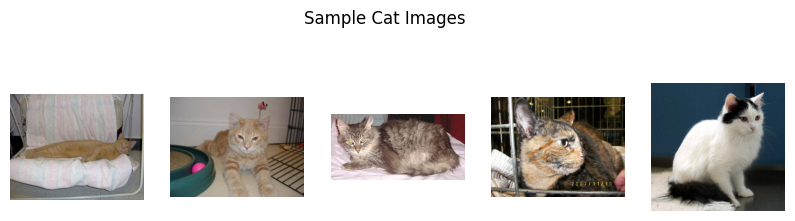

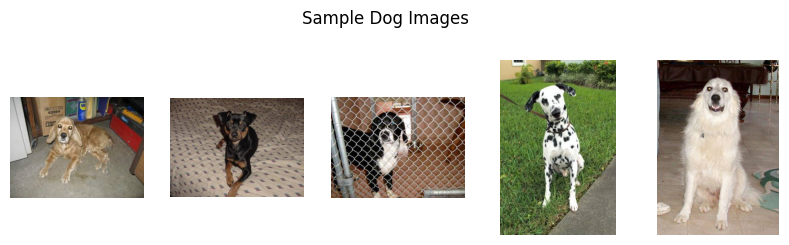

In [4]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths to the directories containing cat and dog images
cat_dir = "Cat_Dog_data/train/cat"
dog_dir = "Cat_Dog_data/train/dog"

# Get a list of file names (images) from each directory
cat_images = [os.path.join(cat_dir, file) for file in os.listdir(cat_dir)[:5]]  # Selecting 5 cat images
dog_images = [os.path.join(dog_dir, file) for file in os.listdir(dog_dir)[:5]]  # Selecting 5 dog images

# Function to display images
def show_images(images, title):
    plt.figure(figsize=(10, 5))
    for i, img_path in enumerate(images):
        plt.subplot(2, 5, i+1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display sample cat images
show_images(cat_images, "Sample Cat Images")

# Display sample dog images
show_images(dog_images, "Sample Dog Images")

In [5]:
from keras.preprocessing.image import ImageDataGenerator

# Define paths to the train and test directories
train_dir = "Cat_Dog_data/train"
test_dir = "Cat_Dog_data/test"

# Data preprocessing using ImageDataGenerator for train and test sets
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for train and test sets
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [6]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout
from keras.applications import InceptionV3
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D

IMG_WIDTH, IMG_HEIGHT = 150, 150

# Create a base model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Fine-tuning the last few layers of the base model
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Add GlobalAveragePooling2D instead of Flatten for better performance
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate and Adam optimizer
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 3, 3, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 22327585 (85.17 MB)
Trainable params: 524801 (2.00 MB)
Non-trainable params: 21802784 (83.17 MB)
___________

In [7]:
# Fit the model
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=10,
                    validation_data=test_generator,
                    validation_steps=test_generator.samples // test_generator.batch_size,)

Epoch 1/10
703/703 [==============================] - 184s 245ms/step - loss: 0.2082 - acc: 0.9239 - val_loss: 0.0928 - val_acc: 0.9635
Epoch 2/10
703/703 [==============================] - 181s 258ms/step - loss: 0.1475 - acc: 0.9402 - val_loss: 0.0935 - val_acc: 0.9607
Epoch 3/10
703/703 [==============================] - 169s 241ms/step - loss: 0.1384 - acc: 0.9427 - val_loss: 0.0871 - val_acc: 0.9623
Epoch 4/10
703/703 [==============================] - 168s 239ms/step - loss: 0.1356 - acc: 0.9474 - val_loss: 0.0794 - val_acc: 0.9663
Epoch 5/10
703/703 [==============================] - 167s 237ms/step - loss: 0.1317 - acc: 0.9461 - val_loss: 0.0820 - val_acc: 0.9683
Epoch 6/10
703/703 [==============================] - 168s 239ms/step - loss: 0.1356 - acc: 0.9436 - val_loss: 0.0773 - val_acc: 0.9675
Epoch 7/10
703/703 [==============================] - 174s 247ms/step - loss: 0.1337 - acc: 0.9449 - val_loss: 0.0788 - val_acc: 0.9692
Epoch 8/10
703/703 [============================

Last train accuracy: 0.948771595954895
Last validation accuracy: 0.9691506624221802


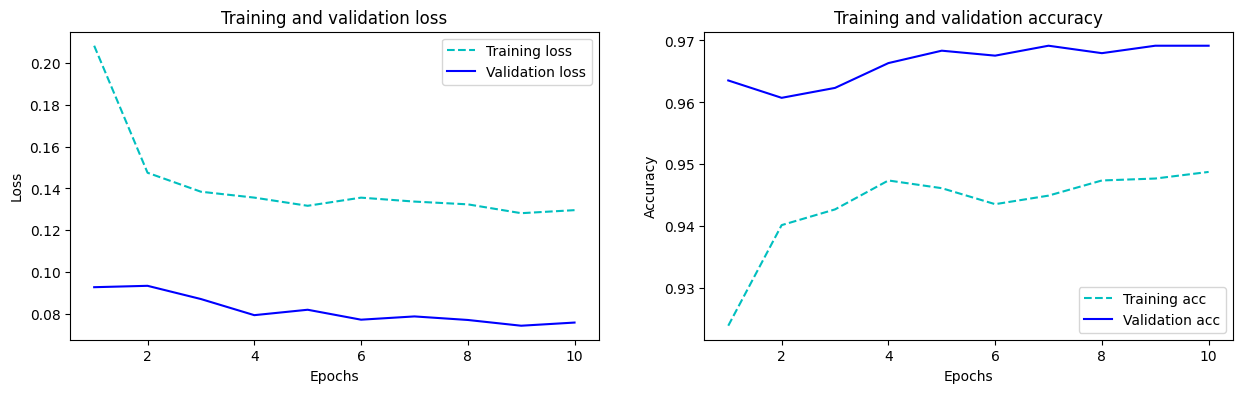

In [8]:
# Show training and validation results
show_result(history)

In [70]:
# Get features and labels for the test set
test_features, test_labels = next(test_generator)

# Using the evaluation function with your test data
pred_class = evaluation_report(model, test_features, test_labels)

1/1 [==============================] - 0s 43ms/step
[[22  0]
 [ 2  8]]
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96        22
         1.0       1.00      0.80      0.89        10

    accuracy                           0.94        32
   macro avg       0.96      0.90      0.92        32
weighted avg       0.94      0.94      0.94        32

Loss: 0.1263 Accuracy: 0.9375


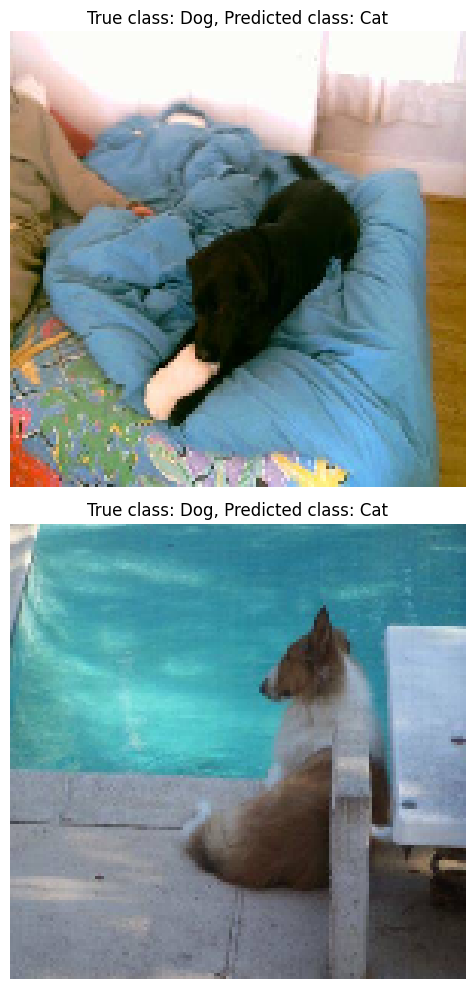

In [71]:
show_false_predictions(test_features, test_labels, pred_class, class_names=['Cat', 'Dog'], num_samples=10)

1/1 [==============================] - 0s 211ms/step


<ipython-input-2-5e6e8525aec4>:119: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.imshow(display_grid, aspect='auto', cmap='viridis')
/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  fig.patch.set_bounds(x0 / w1, y0 / h1,
/usr/local/lib/python3.10/dist-packages/matplotlib/_tight_bbox.py:65: RuntimeWarning: divide by zero encountered in double_scalars
  fig.bbox.width / w1, fig.bbox.height / h1)
/usr/local/lib/python3.10/dist-packages/matplotlib/patches.py:739: RuntimeWarning: invalid value encountered in double_scalars
  y1 = self.convert_yunits(self._y0 + self._height)
/usr/local/lib/python3.10/dist-packages/matplotlib/transforms.py:2042: RuntimeWarning: invalid value encountered in double_scalars
  self._mtx[1, 2] += ty


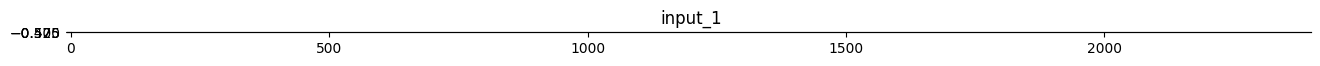

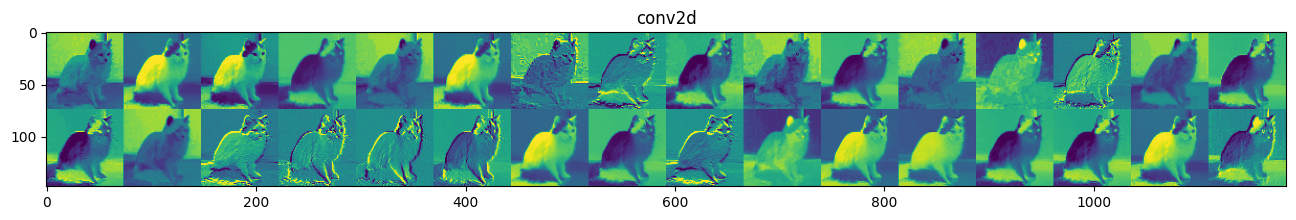

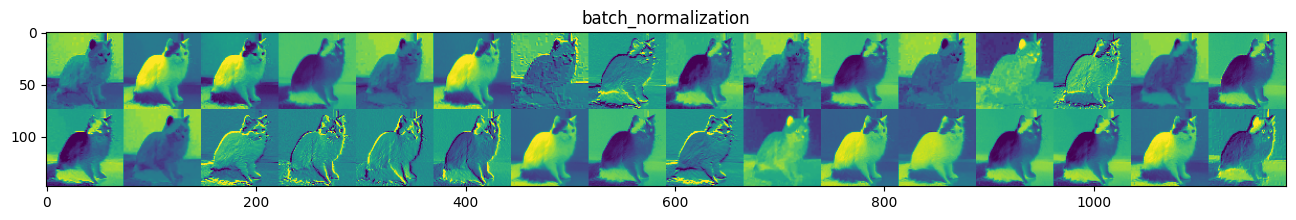

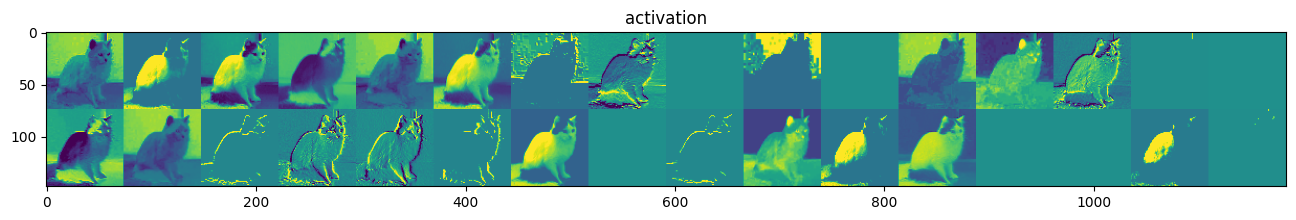

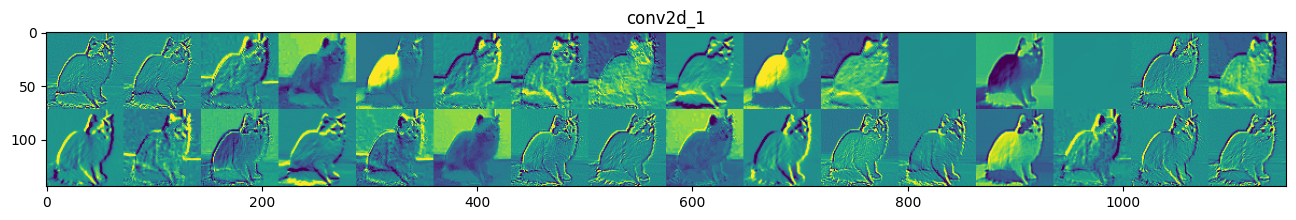

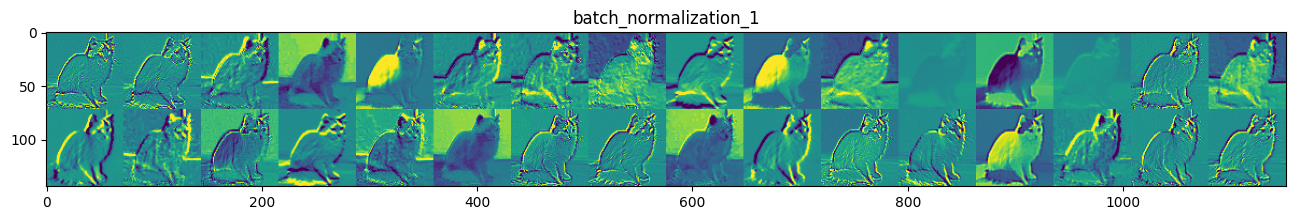

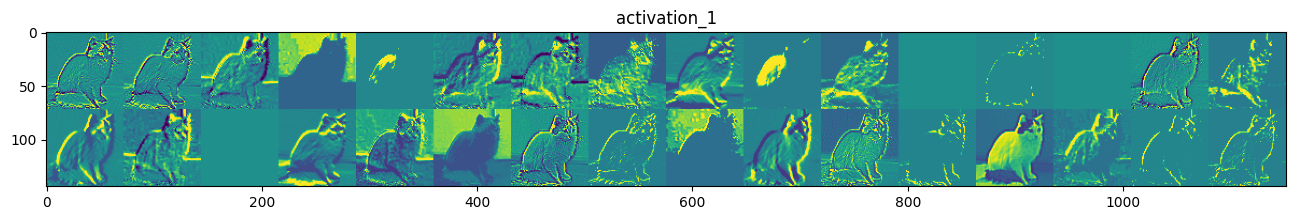

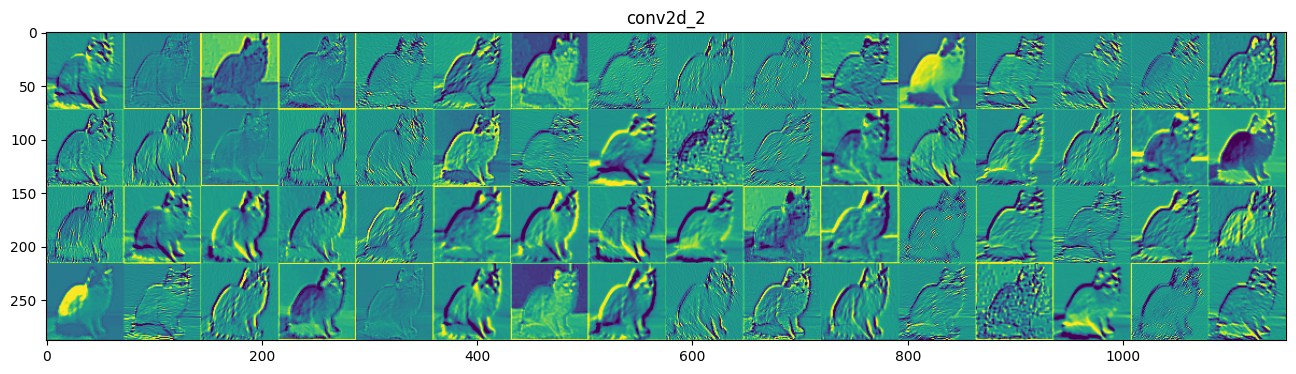

In [11]:
from keras.models import Model

# Define the number of layers you want to visualize (change this number as needed)
num_layers_to_visualize = 8  # Change this number to visualize activations from the first n layers

# Extract activations from the selected layers of InceptionV3
layer_outputs = [layer.output for layer in base_model.layers[:num_layers_to_visualize]]

# Create a new model to extract activations from the specified layers
activation_model = Model(inputs=base_model.input, outputs=layer_outputs)

from keras.preprocessing import image

# Load an image to feed into the network
img = image.load_img(cat_images[4], target_size=(IMG_WIDTH, IMG_HEIGHT))
img_tensor = image.img_to_array(img)
img_tensor = img_tensor.reshape((1, img_tensor.shape[0], img_tensor.shape[1], img_tensor.shape[2]))
img_tensor = img_tensor / 255.0  # Normalize pixel values to [0, 1]

# Feed into the activation model to get activations for selected layers
activations = activation_model.predict(img_tensor)

# Visualize the activations for the selected layers
show_layer_activation(activations, activation_model, num_layers_to_visualize)
